# HACK-IT!

## 0. Introduction

The objective of this project is to identify 5 patterns from the [US Traffic 2015](https://www.kaggle.com/jboysen/us-traffic-2015) dataset that is publicly available on Kaggle. It will cover explorary analysis of the dataset, data cleaning, and data visualisation to arrive at the 5 hypotheses. The project will conclude with a tree-based feature importance assessment of the potential validity of the hypotheses along with an additional neural-network-based assessment of the feature weights and directionality as appendix. Based on the findings, potential use cases may include capacity management of public road infrastructure and traffic coordination to manage congestion issues, which are regarded to be beyond the scope of this project.

## 1. Exploratory Analysis

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset & deduplication
data = pd.read_csv('data/dot_traffic_2015.txt.gz', compression='gzip')
data.drop_duplicates(inplace=True)

print('There are {:,} records of {} variables.'.format(data.shape[0],data.shape[1]))

There are 6,396,747 records of 38 variables.


In [4]:
# Column names & missing values
data.isna().sum()

date                                               0
day_of_data                                        0
day_of_week                                        0
direction_of_travel                                0
direction_of_travel_name                           0
fips_state_code                                    0
functional_classification                          0
functional_classification_name                     0
lane_of_travel                                     0
month_of_data                                      0
record_type                                        0
restrictions                                 6396747
station_id                                         0
traffic_volume_counted_after_0000_to_0100          0
traffic_volume_counted_after_0100_to_0200          0
traffic_volume_counted_after_0200_to_0300          0
traffic_volume_counted_after_0300_to_0400          0
traffic_volume_counted_after_0400_to_0500          0
traffic_volume_counted_after_0500_to_0600     

Firstly, the numeric features can be summarised as below:

* The time-series features include `day_of_data`, `month_of_data`, `year_of_data`, and `day_of_week`. It can be noted that the dataset captures a full year of records in the year of 2015.
* The volume features are in the form `traffic_volume_counted_after_[xxxx]_to_[xxxx]`. It can be observed that there are significant outliers and negative values that need to be cleaned for a proper analysis.
* Some numeric features are categorical in nature, including `direction_of_travel`, `fips_state_code`, and `lane_of_travel`.
* There are also features that can be considered as irrelevant for our purpose. These include `restrictions` (that is missing for all records) and `record_type` (that holds the same value for all records).

In [5]:
# Describe the data
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
day_of_data,6396747.0,15.73,8.77,1.0,8.0,16.0,23.0,31.0
day_of_week,6396747.0,4.01,1.99,1.0,2.0,4.0,6.0,7.0
direction_of_travel,6396747.0,3.88,2.29,0.0,1.0,5.0,5.0,9.0
fips_state_code,6396747.0,29.81,17.05,1.0,13.0,30.0,47.0,56.0
lane_of_travel,6396747.0,1.27,1.09,0.0,0.0,1.0,2.0,9.0
month_of_data,6396747.0,6.51,3.46,1.0,4.0,7.0,10.0,12.0
record_type,6396747.0,3.00,0.00,3.0,3.0,3.0,3.0,3.0
restrictions,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traffic_volume_counted_after_0000_to_0100,6396747.0,119.16,295.51,-1.0,13.0,42.0,129.0,99999.0
traffic_volume_counted_after_0100_to_0200,6396747.0,82.00,231.32,-1.0,8.0,27.0,87.0,80741.0


In [6]:
# The dataset contains a full year of records
data.date.value_counts().sort_index()

2015-01-01    16611
2015-01-02    17319
2015-01-03    17111
2015-01-04    17137
2015-01-05    16298
              ...  
2015-12-27    17237
2015-12-28    16911
2015-12-29    16839
2015-12-30    16946
2015-12-31    17095
Name: date, Length: 365, dtype: int64

In [7]:
# Negative values can be regarded as missing values in traffic volume
data_temp = data.loc[:,data.columns.str.startswith('traffic_volume')].melt()
data_temp = data_temp[data_temp.value<0]
data_temp.value.value_counts()

-1       1448
-3061       1
Name: value, dtype: int64

In [8]:
# Extreme values in traffic volume
data_temp = data.loc[:,data.columns.str.startswith('traffic_volume')].melt()
data_temp = data_temp[data_temp.value>90000]
data_temp.value.value_counts()

99999    69
90009    18
90011    18
90026    16
90038    16
         ..
90096     1
90300     1
92300     1
90055     1
90111     1
Name: value, Length: 162, dtype: int64

Secondly, the categorical features can be summarised as below:

* There is a total of 5,142 stations measuring traffic across 51 states. Based on the available data, each road can hold up to 9 lanes, although it is possible that each station would not capture the traffic of all lanes on the same road. As a form of data normalisation, we will take the average of traffic volume across all lanes along the same combination of `fips_state_code`, `station_id`, and `direction_of_travel`.
* There is a total of 10 possible directions. The `direction_of_travel` feature is a useful when used in together with the `fips_state_code` and `station_id` as a conjugate key to identify the road in question.
* The roads are categorised into 7 functional classifications and further distinguished between rural and urban.

In [9]:
# Counts of states and stations
print('No. of States  : {:>8}'.format(len(np.unique(data.fips_state_code))))
print('No. of Stations: {:>8,}'.format(len(np.unique(data.station_id))))

No. of States  :       51
No. of Stations:    5,142


In [10]:
# Each station can be found in multiple states
data.groupby('station_id').fips_state_code.count()

station_id
000001     8563
000002     9906
000003    12197
000004    13299
000005     8555
          ...  
WIM104     1568
WIM114     1544
WIM118     1192
r01000      248
r02000     2982
Name: fips_state_code, Length: 5142, dtype: int64

In [11]:
# There can be up to 9 lanes of travel per road
data.lane_of_travel.value_counts().sort_index()

0    1618857
1    2518176
2    1554696
3     462985
4     165303
5      49709
6      20114
7       5932
8        905
9         70
Name: lane_of_travel, dtype: int64

In [12]:
# There can be up to 10 directions of travel
data.loc[:,['direction_of_travel','direction_of_travel_name']].value_counts().sort_index()

direction_of_travel  direction_of_travel_name                                       
0                    East-West or Southeast-Northwest combined (ATR stations only)        31465
1                    North                                                              1811724
2                    Northeast                                                            25289
3                    East                                                               1288227
4                    Southeast                                                            39945
5                    South                                                              1796371
6                    Southwest                                                            24999
7                    West                                                               1280180
8                    Northwest                                                            38203
9                    North-South or Northeast-South

In [13]:
# There are 7 core functional classifications further distinguished by rural or urban
data.loc[:,['functional_classification','functional_classification_name']].value_counts().sort_index()

functional_classification  functional_classification_name                           
1R                         Rural: Principal Arterial - Interstate                        911973
1U                         Urban: Principal Arterial - Interstate                       1524165
2U                         Urban: Principal Arterial - Other Freeways or Expressways     588606
3R                         Rural: Principal Arterial - Other                            1237074
3U                         Urban: Principal Arterial - Other                            1010647
4R                         Rural: Minor Arterial                                         445374
4U                         Urban: Minor Arterial                                         283127
5R                         Rural: Major Collector                                        276168
5U                         Urban: Collector                                               71244
6R                         Rural: Minor Collector  

In [14]:
# Create mappers for short to long names
mapper_dot = {
    k : v for (k,v) in (
        data
        .loc[:,['direction_of_travel','direction_of_travel_name']]
        .drop_duplicates()
        .sort_values(by='direction_of_travel')
        .values
    )}

mapper_fcl = {
    k : v for (k,v) in (
        data
        .loc[:,['functional_classification','functional_classification_name']]
        .drop_duplicates()
        .sort_values(by='functional_classification')
        .values
    )}

mapper_dow = {
    1 : 'Sun',
    2 : 'Mon',
    3 : 'Tue',
    4 : 'Wed',
    5 : 'Thu',
    6 : 'Fri',
    7 : 'Sat',
}

## 3. Data Cleaning

The data cleaning step seeks to aggregate the hourly traffic data by the following keys: `fips_state_code`, `station_id`, `direction_of_travel`. It takes the average of traffic volume across all lanes for each timestamp. Extreme values will be restricted up to 3 standard deviations from the observed means for each set of conjugate keys. This will be achieved using the `tmean` and `tstd` functions from the `scipy` library to minimise the impact from extreme values. Further, negative values will be baselined to 0. The resulting dataset will be transposed to its long form to facilitate subsequent analytics and modelling.

In [15]:
# Helper functions for trimmed mean and std
from scipy.stats import tmean, tstd

def trim_mean(x):
    return tmean(x.dropna())

def trim_std(x):
    return tstd(x.dropna())

# Replace -3601, -1, 99999 values with missing values
for col in data.columns[data.columns.str.startswith('traffic_volume')]:
    data[col] = np.where((data[col]<0)|(data[col]==99999), np.nan, data[col])

# Calcuate trimmed mean
data_mu = (
    data
    .groupby(['fips_state_code','station_id','direction_of_travel'])
    .agg({
         x : trim_mean for x in data.columns[data.columns.str.startswith('traffic_volume')]
    }))

# Calcualte trimmed std
data_sd = (
    data
    .groupby(['fips_state_code','station_id','direction_of_travel'])
    .agg({
         x : trim_std for x in data.columns[data.columns.str.startswith('traffic_volume')]
    }))

In [16]:
# Calculate lower bounds, minimum value of 0
data_lower = data_mu.values - 3*data_sd.values
data_lower = np.where(data_lower<0, 0, data_lower)

data_lower = pd.DataFrame(data_lower, index=data_mu.index, columns=['lower_'+x.split('_')[-1] for x in data_mu.columns])
data_lower.head()

lower_0100  lower_0200  \
fips_state_code station_id direction_of_travel                           
1               000002     3                           0.0         0.0   
                           7                           0.0         0.0   
                000004     3                           0.0         0.0   
                           7                           0.0         0.0   
                000006     1                           0.0         0.0   

                                                lower_0300  lower_0400  \
fips_state_code station_id direction_of_travel                           
1               000002     3                           0.0         0.0   
                           7                           0.0         0.0   
                000004     3                           0.0         0.0   
                           7                           0.0         0.0   
                000006     1                           0.0         0.0   

                                                lower_0500  lower_0600  \
fips_state_code station_id direction_of_travel                           
1               000002     3                           0.0         0.0   
                           7                           0.0         0.0   
                000004     3                           0.0         0.0   
                           7                           0.0         0.0   
                000006     1                           0.0         0.0   

                                                lower_0700  lower_0800  \
fips_state_code station_id direction_of_travel                           
1               000002     3                           0.0         0.0   
                           7                           0.0         0.0   
                000004     3                           0.0         0.0   
                           7                           0.0         0.0   
                000006     1                           0.0         0.0   

                                                lower_0900  lower_1000  ...  \
fips_state_code station_id direction_of_travel                          ...   
1               000002     3                       0.00000    0.000000  ...   
                           7                       0.00000    0.000000  ...   
                000004     3                       0.00000    0.000000  ...   
                           7                       0.00000    0.000000  ...   
                000006     1                      27.98297   51.825973  ...   

                                                lower_1500  lower_1600  \
fips_state_code station_id direction_of_travel                           
1               000002     3                     10.234146   16.200134   
                           7                      0.000000    0.000000   
                000004     3                      0.000000   42.803909   
                           7                     98.345953  147.689496   
                000006     1                     51.316895   46.806290   

                                                lower_1700  lower_1800  \
fips_state_code station_id direction_of_travel                           
1               000002     3                      0.000000    0.000000   
                           7                      0.000000    0.000000   
                000004     3                     45.010460   34.343087   
                           7                    109.471661   22.123624   
                000006     1                     43.530436   36.979295   

                                                lower_1900  lower_2000  \
fips_state_code station_id direction_of_travel                           
1               000002     3                      0.000000         0.0   
                           7                      0.000000         0.0   
                000004     3                      0.000000         0.0   
          

In [17]:
# Calculate upper bounds
data_upper = data_mu.values + 3*data_sd.values
data_upper = np.where(data_upper<0, 0, data_upper)

data_upper = pd.DataFrame(data_upper, index=data_mu.index, columns=['upper_'+x.split('_')[-1] for x in data_mu.columns])
data_upper.head()

upper_0100  upper_0200  \
fips_state_code station_id direction_of_travel                           
1               000002     3                    127.160381   89.265392   
                           7                    116.501312   86.327623   
                000004     3                    463.859297  464.889397   
                           7                    353.035202  353.814727   
                000006     1                     18.663795   13.520903   

                                                upper_0300  upper_0400  \
fips_state_code station_id direction_of_travel                           
1               000002     3                     79.502976  120.037740   
                           7                    133.455657  252.329933   
                000004     3                    473.510760  435.434675   
                           7                    289.695131  261.145925   
                000006     1                     11.070266   14.102568   

                                                upper_0500  upper_0600  \
fips_state_code station_id direction_of_travel                           
1               000002     3                    171.999038  258.480411   
                           7                    360.220583  492.109829   
                000004     3                    510.456488  638.842971   
                           7                    347.531898  571.592288   
                000006     1                     32.120285  158.669593   

                                                upper_0700  upper_0800  \
fips_state_code station_id direction_of_travel                           
1               000002     3                    325.779982  419.949120   
                           7                    633.803708  623.971138   
                000004     3                    709.196504  772.043776   
                           7                    824.370666  959.299587   
                000006     1                    205.973281  235.056225   

                                                upper_0900  upper_1000  ...  \
fips_state_code station_id direction_of_travel                          ...   
1               000002     3                    443.423067  481.887227  ...   
                           7                    557.329333  537.405719  ...   
                000004     3                    790.358711  843.572182  ...   
                           7                    847.385879  861.048375  ...   
                000006     1                    178.692988  153.909219  ...   

                                                 upper_1500   upper_1600  \
fips_state_code station_id direction_of_travel                             
1               000002     3                     559.418162   585.532174   
                           7                     525.966340   531.772695   
                000004     3                    1082.944019  1102.282959   
                           7                    1018.312633  1073.187272   
                000006     1                     145.038506   134.894058   

                                                 upper_1700   upper_1800  \
fips_state_code station_id direction_of_travel                             
1               000002     3                     659.998703   668.390525   
                           7                     543.142897   540.500099   
                000004     3                    1055.850146  1001.929640   
                           7                    1040.172784   975.072336   
                000006     1                     138.727403   131.083423   

                                                upper_1900  upper_2000  \
fips_state_code station_id direction_of_travel                           
1               000002     3                    574.524222  504.109553   
                           7                    499.442282  430.912430   
                000004     3                    856.2707

In [18]:
# Merge lower and upper bounds to dataset 
data_clean = (
    data
    .merge(data_lower, how='left', on=['fips_state_code','station_id','direction_of_travel'])
    .merge(data_upper, how='left', on=['fips_state_code','station_id','direction_of_travel']))

In [19]:
# Limit observersations to lower and upper bounds
for t in [x.split('_')[-1] for x in data_mu.columns]:
    
    col = data_clean.columns[(data_clean.columns.str.startswith('traffic_volume'))&\
                             (data_clean.columns.str.endswith(t))].values[0]
    
    data_clean[col] = np.where(data_clean[col].values<data_clean['lower_'+t].values, 
                               data_clean['lower_'+t].values, data_clean[col].values)
    
    data_clean[col] = np.where(data_clean[col].values>data_clean['upper_'+t].values, 
                               data_clean['upper_'+t].values, data_clean[col].values)

In [20]:
# Drop lower and upper bounds from dataset
data_clean.drop(data_clean.columns[(data_clean.columns.str.startswith('lower_'))|\
                                   (data_clean.columns.str.startswith('upper_'))], 
                axis=1, inplace=True)

In [21]:
# Check missing values at record level
data_clean.drop(['restrictions'], axis=1).isna().max(axis=1).sum()

884

In [22]:
# Drop records with missing values (884 of 6.4m records ~<0.02%)
data_clean = data_clean.drop(['restrictions'], axis=1).dropna()
data_clean.shape

(6395863, 37)

In [23]:
# Aggregate data by conjugate keys
data_agg = (
    data_clean
    .groupby([
        'fips_state_code','station_id','direction_of_travel',
        'date', 'month_of_data', 'day_of_week', 
        'functional_classification'])
    .agg({
        x : 'mean' for x in data_clean.columns[data_clean.columns.str.startswith('traffic_volume')]}))

In [24]:
# Rename columns & transpose to long-form
data_agg.columns = [x.split('_')[-1] for x in data_agg.columns]
data_agg = data_agg.melt(ignore_index=False, var_name='time', value_name='traffic')

In [25]:
# Calculate log_traffic
data_agg['log_traffic'] = np.log1p(data_agg['traffic'])

In [26]:
# Convert data types to reduce memory usage
data_agg['traffic']     = data_agg['traffic'].astype(np.float32)
data_agg['log_traffic'] = data_agg['log_traffic'].astype(np.float32)

In [27]:
# Reset index
data_agg.reset_index(inplace=True)

In [28]:
# Check output sample
data_agg.head()

,fips_state_code,station_id,direction_of_travel,date,month_of_data,day_of_week,functional_classification,time,traffic,log_traffic
0,1,000002,3,2015-01-02,1,6,3R,0100,9.5,2.351375
1,1,000002,3,2015-01-03,1,7,3R,0100,20.0,3.044523
2,1,000002,3,2015-01-04,1,1,3R,0100,13.0,2.639057
3,1,000002,3,2015-01-05,1,2,3R,0100,14.5,2.740840
4,1,000002,3,2015-01-06,1,3,3R,0100,12.0,2.564949


In [29]:
# Check output shape
data_agg.shape

(89590800, 10)

In [30]:
# Clean-up workspace
del data, data_lower, data_upper, data_clean

## 4. Data Visualisation

<b>Hypothesis 1: Low traffic volume during the year-end holiday season</b>

From a time-series approach, it can be observed per our expectations that the median traffic volume peaks in the middle of the year and tapers down towards the year-end holday season. This suggests the period of year can be an important factor to determine traffic volume. Furthermore, there is visible evidence of weekly patterns in traffic volume that we can explore in the next hypothesis.

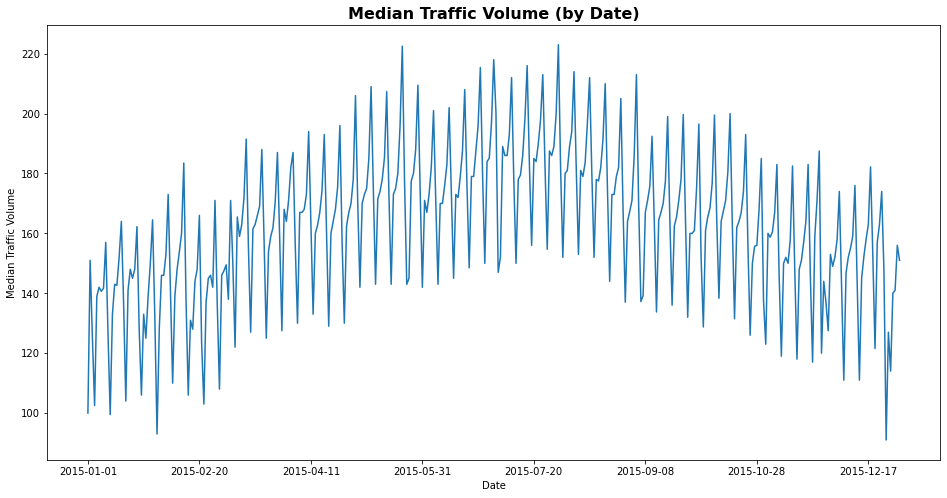

In [31]:
# Plot the distribution of traffic volume across the year
plt.figure(figsize=(16,8))
data_agg.groupby('date').traffic.median().plot()
plt.title('Median Traffic Volume (by Date)', fontweight='bold', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Median Traffic Volume')
plt.show()

<b>Hypothesis 2: High traffic volume every Friday from weekend travellers</b>

Extending from Hypothesis 1, it can be observed that the median weekly traffic volume peaks on Friday and is the lowest on Sunday. The high weekday traffic volume is likely associated with day-to-day office commuters whereas the exceptional Friday peak cannot be ascertained from the available data. However, it can be possible that the Friday peak is due to an increase in traffic from weekend travellers with a spillover effect into Saturday.

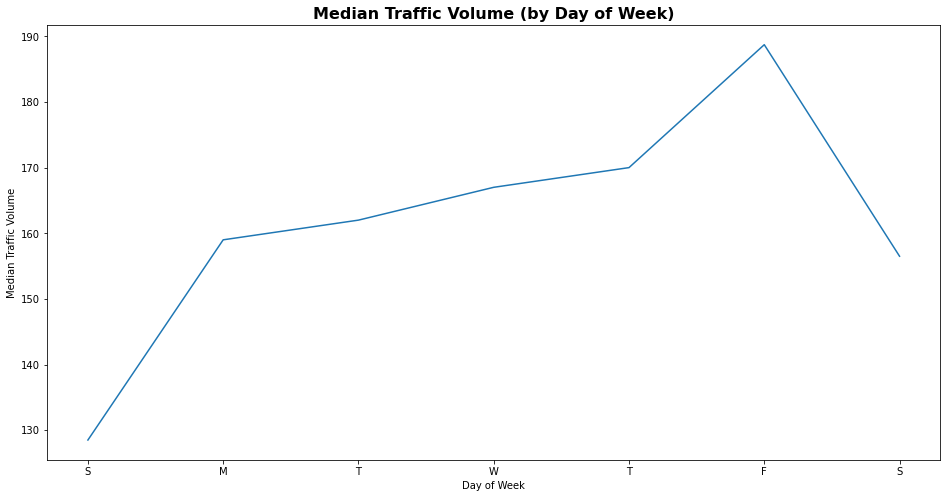

In [32]:
# Plot the distribution of traffic volume across the week
plt.figure(figsize=(16,8))
data_agg.groupby('day_of_week').traffic.median().plot()
plt.title('Median Traffic Volume (by Day of Week)', fontweight='bold', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Median Traffic Volume')
plt.xticks(np.arange(1,8,1), ['S','M','T','W','T','F','S'])
plt.show()

<b>Hypothesis 3: Visible traffic from 0600hr to 0000hr</b>

Per expectations, traffic volume is visibly low during the wee hours prior to 0600hr. Traffic volumes increases during the morning commute before it gradually decreases in the evening after 18800hr.

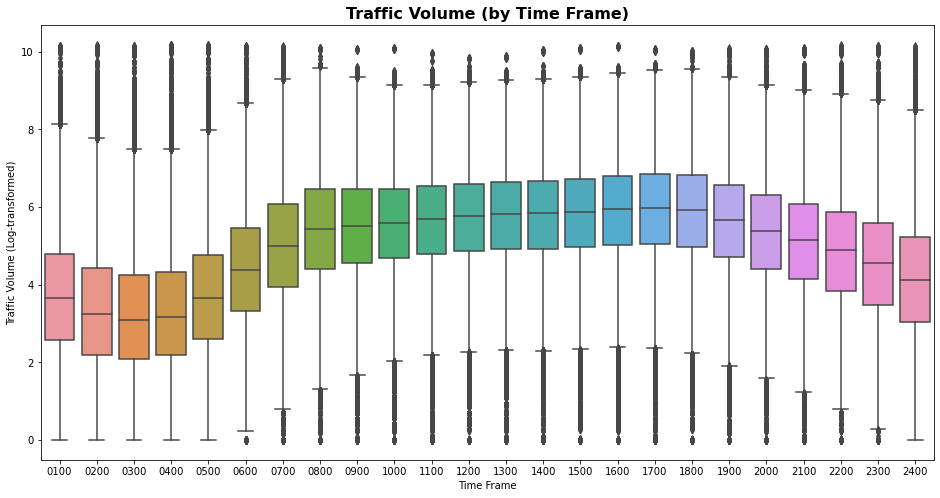

In [33]:
# Plot the distribution of traffic volume across time frame
plt.figure(figsize=(16,8))
sns.boxplot(x=data_agg.time, y=data_agg.log_traffic)
plt.title('Traffic Volume (by Time Frame)', fontweight='bold', fontsize=16)
plt.xlabel('Time Frame')
plt.ylabel('Traffic Volume (Log-transformed)')
plt.show()

<b>Hypothesis 4: High traffic volume in populous states</b>

From the distribution below, it can be observed that traffic volume is generally higher in the more populous states, including but not limited to the following, in ascending order of `fips_state_code`:

* Arizona (*4*)
* California (*6*)
* Connecticut (*9*)
* Columbia (*11*)
* Maryland (*24*)
* Massachusetts (*25*)
* Michigan (*26*)
* Rhode Island (*44*)
* South Carolina (*45*)
* Virginia (*51*)

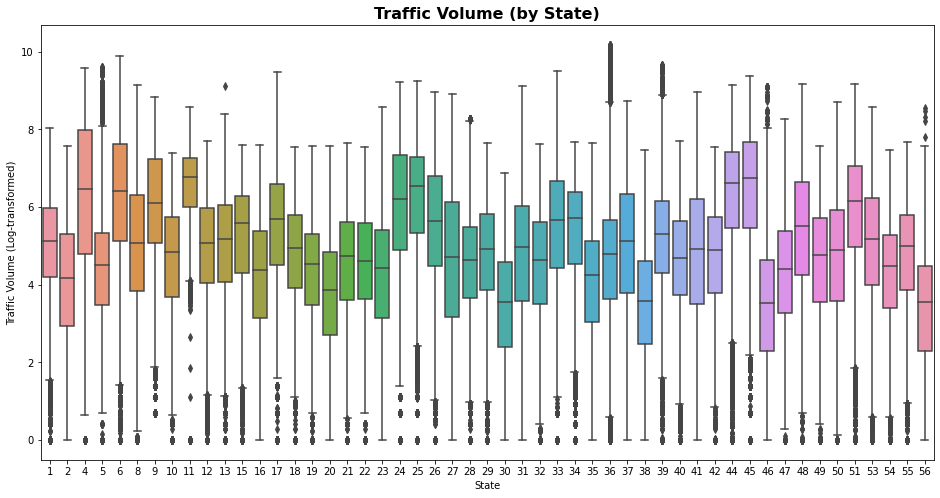

In [34]:
# Plot the distribution of traffic volume by states
plt.figure(figsize=(16,8))
sns.boxplot(x=data_agg.fips_state_code, y=data_agg.log_traffic)
plt.title('Traffic Volume (by State)', fontweight='bold', fontsize=16)
plt.xlabel('State')
plt.ylabel('Traffic Volume (Log-transformed)')
plt.show()

<b>Hypothesis 5: High traffic volume on the principal arterials</b>

From the distribution below, it can be observed that the traffic volume is highest on *1U* and *1R* (being the interstate principal arterials) and *2U* (being the freeways or expressways). Furthermore, it can be observed that the *urban* counterpart of the respective functional classifications generally have higher traffic than the *rural* counterpart.

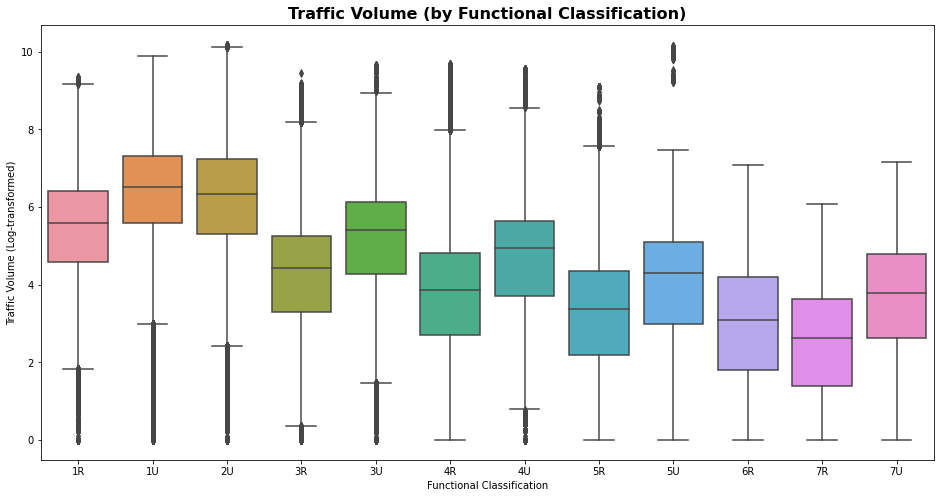

In [35]:
# Plot the distribution of traffic volume by road function
plt.figure(figsize=(16,8))
sns.boxplot(
    data=data_agg.sort_values(by='functional_classification'),
    x='functional_classification', y='log_traffic')
plt.title('Traffic Volume (by Functional Classification)', fontweight='bold', fontsize=16)
plt.xlabel('Functional Classification')
plt.ylabel('Traffic Volume (Log-transformed)')
plt.show()

## 5. Feature Engineering

To support the above hypothesis, we can use the tree-based method to determine the importance of each feature in determining the traffic volume. For the purpose of illustration and in consideration of memory capacity and processing efficiency, the model will be trained and evaluated on 1% of the 90m records, totalling ~1m sample size. Sampling is performed using the stratified method to obtain a representative sample of the population across the feature dimensions.

In [36]:
# Import library
from sklearn.model_selection import train_test_split

In [37]:
# Take 1% stratified model development sample
x_train, x_test, y_train, y_test = train_test_split(
    data_agg.iloc[:,-2:], data_agg.iloc[:,:-2].drop(['date'], axis=1), 
    train_size=0.01, random_state=42)

x_train.shape, y_train.shape

((895908, 2), (895908, 7))

On the reduced dataset, categorical features are converted to *string* values to enable a subsequent one-hot encoding. The following new features are also created to capture the nuances observed from the above visualisations:

* Time bins: `time_04hr`, `time_06hr`, `time_08hr`
* Weekdays:  `weekday`, `day_of_week`
* Quarters:  `quarter_of_data`
* Functions: `functional_classification_1`, `functional_classification_2`

In [38]:
y_train['fips_state_code']     = y_train['fips_state_code'].apply(lambda x: str(x).zfill(2))
y_train['direction_of_travel'] = y_train['direction_of_travel'].apply(lambda x: str(x).zfill(2))

y_train['time_04hr'] = y_train['time'].apply(lambda x: str((int(x)//100-1)//4+1).zfill(2))
y_train['time_06hr'] = y_train['time'].apply(lambda x: str((int(x)//100-1)//6+1).zfill(2))
y_train['time_08hr'] = y_train['time'].apply(lambda x: str((int(x)//100-1)//8+1).zfill(2))

y_train['weekday']     = y_train['day_of_week'].apply(lambda x: 'Y' if 2<=x<=6 else 'N')
y_train['day_of_week'] = y_train['day_of_week'].apply(lambda x: str(x).zfill(2))

y_train['quarter_of_data'] = y_train['month_of_data'].apply(lambda x: str((x-1)//3+1).zfill(2))
y_train['month_of_data']   = y_train['month_of_data'].apply(lambda x: str(x).zfill(2))

y_train['functional_classification_1'] = y_train['functional_classification'].apply(lambda x: x[0])
y_train['functional_classification_2'] = y_train['functional_classification'].apply(lambda x: x[1])

In [39]:
# Feature columns for tree-based model training
feature_col = [
    'fips_state_code', 'direction_of_travel',
    'time', 'time_04hr', 'time_06hr', 'time_08hr',
    'month_of_data', 'quarter_of_data', 'day_of_week', 'weekday',
    'functional_classification', 
    'functional_classification_1', 
    'functional_classification_2'
]

# One-hot encoding for categorical features
y_train = pd.get_dummies(y_train.loc[:,feature_col])

## 6. Model Training

The algorithm used to determine feature importance is the `RandomForestRegressor` from the *scikit-learn* library. For the purpose of illustration, the `n_estimators` and `max_depth` hyperparameters are preset without further tuning. The `random_state` hyperparameter is used to enable reproducibility. Using these hyperparameters, model training took ~5min with 12 processing cores. The model is saved locally for use in subsequent inference tasks.

In [40]:
# Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import pickle

In [41]:
# Split data into 70% training, 30% testing
x_train, x_test, y_train, y_test = train_test_split(
    y_train, x_train[['log_traffic']], 
    test_size=0.3, random_state=42)

# Save the datasets
x_train.to_csv('x_train.txt.gz', compression='gzip', index=False)
y_train.to_csv('y_train.txt.gz', compression='gzip', index=False)
x_test.to_csv('x_test.txt.gz', compression='gzip', index=False)
y_test.to_csv('y_test.txt.gz', compression='gzip', index=False)

# Load datasets
# x_train = pd.read_csv('x_train.txt.gz', compression='gzip')
# y_train = pd.read_csv('y_train.txt.gz', compression='gzip')
# x_test  = pd.read_csv('x_test.txt.gz', compression='gzip')
# y_test  = pd.read_csv('y_test.txt.gz', compression='gzip')

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((627135, 144), (268773, 144), (627135, 1), (268773, 1))

In [42]:
# Build random forest regressor model
rfr = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

# Fit the model
rfr.fit(x_train, y_train)

# Save the model
with open('rfr_model.pkl', 'wb') as f:
    pickle.dump(rfr, f)

# Load model
# with open('rfr_model.pkl', 'rb') as f:
#     rfr = pickle.load(f)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


From the below findings, it can be observed that the Top-20 features cumulatively account for close to 100% of the feature importance score. While the model appears to downplay the effects of the Friday traffic peaks and the seasonal traffic volume trend as observed from Hypothesis 1 and Hypothesis 2, most of the features of importance support the remaining hypotheses:

* `time_06hr_01` and `time_04hr_06` suggests that the wee hours and late nights have signficantly different traffic volume from the rest of day.
* `functional_classification_[X]_[Y]` suggests that the interstate principal arterials, freeways, and expressways have significantly different traffic volume than the other road functions.
* Few states including Arizona (`fips_state_code_04`), Alaska (`fips_state_code_02`), California (`fips_state_code_06`), and South Dakota (`fips_state_code_46`) have signficantly different traffic volume from the other states.

In [43]:
# Convert feature importance to dataframe
feat_impt = pd.DataFrame(
    rfr.feature_importances_,
    index=x_train.columns,
    columns=['importance']
)

feat_impt.index.name = 'feature'

# Calculate cumulative feature importance
feat_impt.sort_values(by=['importance'], ascending=False, inplace=True)
feat_impt['c. importance'] = feat_impt['importance'].cumsum()

# Show cumulative feature importance of the Top-20 features
feat_impt.head(20).reset_index().round(4)

,feature,importance,c. importance
0,time_06hr_01,0.3395,0.3395
1,functional_classification_1_1,0.1542,0.4937
2,functional_classification_2_R,0.1300,0.6237
3,functional_classification_2_U,0.0814,0.7051
4,time_04hr_06,0.0651,0.7702
5,functional_classification_1R,0.0447,0.8149
6,functional_classification_2U,0.0410,0.8559
7,functional_classification_1_2,0.0359,0.8918
8,functional_classification_1U,0.0213,0.9131
9,fips_state_code_04,0.0196,0.9327


## 7. Model Scoring

For completeness, the model score is presented below in terms of mean-square-error and r2-value. There is evidently room for improvement which will not be covered for the purpose of this illustration. Potential approaches may include, but is not limited to, feature selection, dimensionality reduction, hyperparameter tuning, and the use of more complex models such as neural networks to capture the nuances of interactions between the many features.

In [44]:
prediction = rfr.predict(x_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


In [45]:
print('mse: {:>8.4f}'.format(mean_squared_error(y_test.log_traffic, prediction)))
print('r2 : {:>8.4f}'.format(r2_score(y_test.log_traffic, prediction)))

mse:   1.2110
r2 :   0.6099


## 8. (Extras) Neural Network for Feature Weights & Directionality

As an extention to the random forest model, we could also use a neural network model to have an understanding of the relative feature weights and directionality in estimating the traffic volume. In this simplified example, we use the input features to directly predict traffic volume with a single hidden layer and dropout layer. As the input feature variables are binary in nature, no further data processing is performed. The feature weights is calculated as an average across the 64 nodes in the single hidden layer. In terms of model scoring, we can observe a much better performance of the neural network model over the random forest model with respect to both mean-square-error and r2-value metrics.

In [46]:
from keras.models import Input, Model
from keras.layers import Dense, Dropout

import keras.backend as K
from keras.callbacks import EarlyStopping

from tensorflow import set_random_seed

K.clear_session()

# Seeding for reproducibility
np.random.seed(42)
set_random_seed(42)

i = Input((x_train.shape[1],), name='Input')
x = Dense(64, name='Dense') (i)
x = Dropout(0.5, name='Dropout') (x)
x = Dense(1, activation='linear', name='Output') (x)

nn = Model(inputs=i, outputs=x, name='Model')

print(nn.summary())

nn.compile(loss='mse', optimizer='adam')
nn.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=20,
    verbose=1,
    validation_data=(x_test,y_test),
    callbacks=[EarlyStopping(monitor='loss',patience=2)]
)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 144)               0         
_________________________________________________________________
Dense (Dense)                (None, 64)                9280      
_________________________________________________________________
Dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 627135 samples, validate on 268773 samples
Epoch 1/20
627135/627135 [==============================] - 4s 6us/step - loss: 

In [47]:
prediction_nn = nn.predict(x_test)

In [48]:
print('mse: {:>8.4f}'.format(mean_squared_error(y_test.log_traffic, prediction_nn)))
print('r2 : {:>8.4f}'.format(r2_score(y_test.log_traffic, prediction_nn)))

mse:   0.8675
r2 :   0.7206


In [49]:
# Convert feature importance to dataframe
feat_impt_nn = pd.DataFrame(
    nn.get_weights()[0].mean(axis=1),
    index=x_train.columns,
    columns=['weight']
)

feat_impt_nn.index.name = 'feature'

feat_impt_nn['abs weight'] = abs(feat_impt_nn['weight'])
feat_impt_nn['sign']       = np.sign(feat_impt_nn['weight']).astype(int)

feat_impt_nn.sort_values(by=['abs weight'], ascending=False, inplace=True)

# Show feature weights of the Top-20 features
feat_impt_nn.head(20).reset_index()

,feature,weight,abs weight,sign
0,fips_state_code_46,-0.061028,0.061028,-1
1,fips_state_code_24,0.054024,0.054024,1
2,fips_state_code_45,0.053045,0.053045,1
3,fips_state_code_04,0.047927,0.047927,1
4,time_06hr_01,-0.045927,0.045927,-1
5,fips_state_code_56,-0.045059,0.045059,-1
6,functional_classification_1_7,-0.043044,0.043044,-1
7,functional_classification_7R,-0.042276,0.042276,-1
8,fips_state_code_11,0.041982,0.041982,1
9,functional_classification_1_6,-0.041932,0.041932,-1


For functional classifications, it is aligned with our above findings and hypotheses that the interstate principal arterials, freeways, and expressways have significantly different traffic volume than the other road functions. Rural and other non-principal roads tend to be associated with reduced traffic volume.

In [50]:
# Feature weights of functional classification features
feat_impt_nn.loc[feat_impt_nn.index.str.startswith('functional_classification_'),:].sort_values(by='weight', ascending=False)

,weight,abs weight,sign
feature,,,
functional_classification_1U,0.030647,0.030647,1
functional_classification_1_2,0.024755,0.024755,1
functional_classification_1_1,0.015503,0.015503,1
functional_classification_1R,0.013231,0.013231,1
functional_classification_4U,0.011000,0.011000,1
functional_classification_3U,0.001933,0.001933,1
functional_classification_2U,-0.001173,0.001173,-1
functional_classification_2_U,-0.001328,0.001328,-1
functional_classification_4R,-0.008108,0.008108,-1


Similarly for the time buckets, it is aligned with our above findings and hypotheses that the wee hours (`time_06hr_01`: before 0600hr) and late nights (`time_04hr_06`: after 1800hr) have signficantly lower traffic volume compared to the rest of day. Furthermore, daytime traffic volume is generally higher (`time_08hr_02`: between 0800hr and 1600hr) than the rest of day.

In [51]:
# Feature weights of time-related features
feat_impt_nn.loc[feat_impt_nn.index.str.startswith('time'),:].sort_values(by='weight', ascending=False)

,weight,abs weight,sign
feature,,,
time_2100,0.041773,0.041773,1
time_04hr_05,0.038146,0.038146,1
time_0800,0.020400,0.020400,1
time_04hr_02,0.018957,0.018957,1
time_04hr_04,0.016646,0.016646,1
time_04hr_03,0.015654,0.015654,1
time_1700,0.015137,0.015137,1
time_08hr_02,0.015018,0.015018,1
time_2200,0.015010,0.015010,1
